In [1]:
%matplotlib inline
from collections import Counter
from matplotlib import pyplot as plt
from IPython.display import Image, display
import matplotlib.image as mpimg

import copy
import json
import numpy as np
import os
import yaml
import re
import shlex
import torch

from tqdm import tqdm

torch.cuda.empty_cache()
# !nvidia-smi

In [2]:
def parse_annotations(annotations):
    types = {}
    qid_to_type = {}
    type_to_qids = {}

    for a in annotations:
        qtype = a['question_type']
        qid = a['question_id']
        if qtype not in types:
            types[qtype] = []
        for answer in a['answers']:
            types[qtype].append(answer['answer'])
        qid_to_type[qid] = qtype
        if qtype not in type_to_qids:
            type_to_qids[qtype] = [qid]
        else:
            type_to_qids[qtype].append(qid)
        
    return types, qid_to_type, type_to_qids

In [3]:
with open('data_prep/vqa_v1.0_cp/vqacp_v1_trainsplit_annotations.json', 'r') as f:
    trainsplit_annotations = json.load(f)
    trainsplit_types, trainsplit_qid_to_type, trainsplit_type_to_qids = parse_annotations(trainsplit_annotations)

In [4]:
with open('data_prep/vqa_v1.0_cp/vqacp_v1_test_annotations.json', 'r') as f:
    test_annotations = json.load(f)
    test_types, test_qid_to_type, test_type_to_qids = parse_annotations(test_annotations)

In [5]:
def viz_prior(qtype, types):
    c = Counter(types[qtype])
    top_k = dict(c.most_common(10))
    other_count = sum(c.values()) - sum(top_k.values())
    top_k['other'] = other_count
    print(top_k)
    plt.pie([float(v) for v in top_k.values()], labels=top_k.keys(),
           autopct=None)
    plt.show()
    return top_k

# VQA model

In [6]:
import numpy as np
import torch

from config.config_utils import finalize_config, dump_config
from train_model.Engineer import one_stage_run_model, masked_unk_softmax
from train_model.dataset_utils import prepare_train_data_set, \
    prepare_eval_data_set, prepare_test_data_set
from train_model.helper import build_model, run_model, print_result
from torch.utils.data import DataLoader

In [7]:
def filter_dataset(dataset, qtype, type_to_qids):
    valid_qids = type_to_qids[qtype]
    imdb_idxs = [0]
    for i, ex in enumerate(dataset.imdb):
        if i > 0:
            qid = ex['question_id']
            if qid in valid_qids:
                imdb_idxs.append(i)
    new_dataset = copy.deepcopy(dataset)
    new_dataset.imdb = dataset.imdb[imdb_idxs]
    return new_dataset

In [8]:
def display_result(info, softmax_res):
    questions = info['question_str']
    images = info['image_name']
    predicted_answers = np.argmax(softmax_res, axis=1)
    answers = []
    for i in range(predicted_answers.shape[0]):
        pred_ans = ans_dic.idx2word(predicted_answers[i])
        print(i, questions[i], images[i], pred_ans)
        answers.append(pred_ans)
    return answers

In [9]:
regularized_model_save = 'results/vqa_v1_adv_cp/training_parameters.lambda_grl.-0.1_lambda_q.0.1_888_kangaroo2/best_model.pth'
baseline_model_save = 'results/vqa_v1_adv_cp/training_parameters.lambda_grl.0_lambda_q.0.001_888_giraffe/best_model.pth'

In [10]:
from config.config import cfg
def process_config(config_file, config_string):
    finalize_config(cfg, config_file, config_string)

process_config('config/keep/vqa_v1_adv_cp.yaml', None)

In [11]:
dataset_test = prepare_test_data_set(**cfg['data'], **cfg['model'])
dataset_test.verbose = True
ans_dic = dataset_test.answer_dict
print("=> Loaded testset: {} examples".format(len(dataset_test)))

=> Loading CP dataset
imdb does not contain ground-truth layout
Loading model and config ...
=> Loaded testset: 125314 examples


In [97]:
qtype = 'is there a'
dataset_filtered = filter_dataset(dataset_test, qtype, test_type_to_qids)
len(dataset_filtered)

6501

In [98]:
data_reader_test = DataLoader(dataset_filtered,
                              shuffle=False,
                              batch_size=min(len(dataset_filtered), 500),
                              num_workers=cfg.data.num_workers)

In [99]:
regularized_model, _ = build_model(cfg, dataset_test)
regularized_model.load_state_dict(torch.load(regularized_model_save)['state_dict'])
regularized_model.eval()
print('done')

done


In [100]:
baseline_model, _ = build_model(cfg, dataset_test)
baseline_model.load_state_dict(torch.load(baseline_model_save)['state_dict'])
baseline_model.eval()
print('done')

done


In [101]:
def get_scores(model, data_reader, ans_dic):
    for i, batch in enumerate(data_reader_test):
        logit_res = one_stage_run_model(batch, model, eval_mode=True)
        softmax_res_tensor = masked_unk_softmax(logit_res, dim=1, mask_idx=ans_dic.UNK_idx)
        info = batch['verbose_info']
        break
    return softmax_res_tensor.data.cpu().numpy().astype(np.float16), info

In [102]:
# def get_scores(model, data_reader, ans_dic):
#     softmax_res_list = []
#     info_list = []
#     for i, batch in enumerate(data_reader_test):
#         logit_res = one_stage_run_model(batch, model, eval_mode=True)
#         softmax_res_tensor = masked_unk_softmax(logit_res, dim=1, mask_idx=ans_dic.UNK_idx)
#         softmax_res_list.append(softmax_res_tensor.data.cpu().numpy().astype(np.float16))
#         info = batch['verbose_info']
#         info_list.append(info)
        
#     softmax_out = np.vstack(softmax_res_list)
#     info_out = {k: [] for k in info_list[0].keys()}
#     for info_d in info_list:
#         for k in info_out.keys():
#             if type(info_d[k]) == list:
#                 info_out[k] = info_out[k] + info_d[k]
    
#     return softmax_out, info_out

In [103]:
baseline_scores, baseline_info = get_scores(baseline_model, data_reader_test, dataset_test.answer_dict)
regularized_scores, regularized_info = get_scores(regularized_model, data_reader_test, dataset_test.answer_dict)

In [104]:
baseline_info.keys()

dict_keys(['image_name', 'image_id', 'question_id', 'feature_path', 'question_str', 'question_tokens', 'all_answers', 'valid_answers'])

In [105]:
baseline_answers = display_result(baseline_info, baseline_scores)

0 Is there a lady or a wig lying on the bed? COCO_train2014_000000296913 woman
1 Is there a particular type of weather that this car would blend into especially well? COCO_train2014_000000341013 no
2 Is there a beef or chicken hot dog? COCO_train2014_000000580685 hot dog
3 Is there a shadow? COCO_train2014_000000487025 no
4 Is there a white sign in the distance? COCO_train2014_000000175121 no
5 Is there a man dressed in blue? COCO_train2014_000000131780 no
6 Is there a picnic table in the photo? COCO_train2014_000000056040 no
7 Is there a painting? COCO_train2014_000000301109 no
8 Is there a two wheeled object in the room? COCO_train2014_000000115005 no
9 Is there a blanket under the saddle? COCO_train2014_000000401720 no
10 Is there a brown bear? COCO_train2014_000000461701 no
11 Is there a clock? COCO_train2014_000000271038 no
12 Is there a keyboard in the foreground of this picture? COCO_train2014_000000213963 no
13 Is there a sink in this room? COCO_train2014_000000485247 no
14 Is 

373 Is there a phone on the bananas? COCO_train2014_000000476634 no
374 Is there a flag on the train? COCO_train2014_000000364491 no
375 Is there a car in the picture behind the lady? COCO_train2014_000000474230 no
376 Is there a cellular phone on the man's food tray? COCO_train2014_000000232279 no
377 Is there a pink and white kite under the blue sky? COCO_train2014_000000539702 no
378 Is there a table lamp in the room? COCO_train2014_000000002349 no
379 Is there a clock on the mantle? COCO_train2014_000000246041 no
380 Is there a couch in the room? COCO_train2014_000000246041 no
381 Is there a number on the man's necktie? COCO_train2014_000000284468 no
382 Is there a stuffed giraffe in pictured? COCO_train2014_000000402770 no
383 Is there a towel? COCO_train2014_000000359354 no
384 Is there a tablecloth under the bowl of oranges? COCO_train2014_000000009866 no
385 Is there a screen on the wall? COCO_train2014_000000428736 no
386 Is there a picnic table here? COCO_train2014_0000001017

In [106]:
regularized_answers = display_result(regularized_info, regularized_scores)

0 Is there a lady or a wig lying on the bed? COCO_train2014_000000296913 inside
1 Is there a particular type of weather that this car would blend into especially well? COCO_train2014_000000341013 yes
2 Is there a beef or chicken hot dog? COCO_train2014_000000580685 hot dog
3 Is there a shadow? COCO_train2014_000000487025 no
4 Is there a white sign in the distance? COCO_train2014_000000175121 yes
5 Is there a man dressed in blue? COCO_train2014_000000131780 yes
6 Is there a picnic table in the photo? COCO_train2014_000000056040 yes
7 Is there a painting? COCO_train2014_000000301109 yes
8 Is there a two wheeled object in the room? COCO_train2014_000000115005 yes
9 Is there a blanket under the saddle? COCO_train2014_000000401720 yes
10 Is there a brown bear? COCO_train2014_000000461701 no
11 Is there a clock? COCO_train2014_000000271038 yes
12 Is there a keyboard in the foreground of this picture? COCO_train2014_000000213963 yes
13 Is there a sink in this room? COCO_train2014_000000485247

247 Is there a volleyball net in this picture? COCO_train2014_000000245142 yes
248 Is there a mountain in the background? COCO_train2014_000000580414 yes
249 Is there a baby changing station in the picture? COCO_train2014_000000507370 no
250 Is there a map of the United States on the wall? COCO_train2014_000000308722 yes
251 Is there a bag in the trash can? COCO_train2014_000000408431 yes
252 Is there a reflection on the side of the bus? COCO_train2014_000000417476 yes
253 Is there a man and a woman? COCO_train2014_000000131277 yes
254 Is there a pot on the stove? COCO_train2014_000000088723 yes
255 Is there a mirror? COCO_train2014_000000276961 yes
256 Is there a kid? COCO_train2014_000000532625 yes
257 Is there a dog in the picture? COCO_train2014_000000201003 no
258 Is there a cup? COCO_train2014_000000012472 yes
259 Is there a flag above the clock? COCO_train2014_000000016720 yes
260 Is there a mountain? COCO_train2014_000000369514 no
261 Is there a clock visible? COCO_train2014_00

371 Is there a door behind the couch? COCO_train2014_000000201949 yes
372 Is there a shadow on this pic? COCO_train2014_000000531236 yes
373 Is there a phone on the bananas? COCO_train2014_000000476634 yes
374 Is there a flag on the train? COCO_train2014_000000364491 yes
375 Is there a car in the picture behind the lady? COCO_train2014_000000474230 yes
376 Is there a cellular phone on the man's food tray? COCO_train2014_000000232279 yes
377 Is there a pink and white kite under the blue sky? COCO_train2014_000000539702 yes
378 Is there a table lamp in the room? COCO_train2014_000000002349 yes
379 Is there a clock on the mantle? COCO_train2014_000000246041 yes
380 Is there a couch in the room? COCO_train2014_000000246041 yes
381 Is there a number on the man's necktie? COCO_train2014_000000284468 yes
382 Is there a stuffed giraffe in pictured? COCO_train2014_000000402770 yes
383 Is there a towel? COCO_train2014_000000359354 yes
384 Is there a tablecloth under the bowl of oranges? COCO_tra

In [107]:
def viz_model_output(softmax_res_tensor, ans_dic):
    values, idxs = softmax_res_tensor.topk(10)
    answers = [ans_dic.idx2word(idx) for idx in idxs]
    scores = [v.item() for v in values]
    
    answers.append('other')
    scores.append(1 - sum(scores))
        
    plt.pie(scores, labels=answers, autopct=None)
    plt.show()

In [108]:
def compare_scores(baseline_scores, baseline_info, regularized_scores, regularized_info, ans_dic, q_idx):
    print('Q:', baseline_info['question_str'][q_idx])
    print('A:', baseline_info['valid_answers'][0][q_idx])
    print('baseline')
    viz_model_output(baseline_scores[q_idx], ans_dic)
    print('regularized')
    viz_model_output(regularized_scores[q_idx], ans_dic)

In [109]:
def sort_model_scores(model_scores, q_idx):
    a_idxs = np.argsort(-model_scores[q_idx])
    answers = [ans_dic.idx2word(idx) for idx in a_idxs]
    scores = model_scores[q_idx][a_idxs]
    return list(zip(answers, scores))

sort_model_scores(baseline_scores, 6)

[('no', 1.0),
 ('yes', 4e-07),
 ('<unk>', 0.0),
 ('pie', 0.0),
 ('pier', 0.0),
 ('pig', 0.0),
 ('pigeon', 0.0),
 ('pigeons', 0.0),
 ('pigtails', 0.0),
 ('pillow', 0.0),
 ('pillows', 0.0),
 ('pilot', 0.0),
 ('pine', 0.0),
 ('pineapple', 0.0),
 ('ping pong', 0.0),
 ('pictures', 0.0),
 ('picture', 0.0),
 ('picnic table', 0.0),
 ('picnic', 0.0),
 ('pickles', 0.0),
 ('pickle', 0.0),
 ('piano', 0.0),
 ('photoshop', 0.0),
 ('photography', 0.0),
 ('photographer', 0.0),
 ('photo', 0.0),
 ('phones', 0.0),
 ('phone', 0.0),
 ('phillies', 0.0),
 ('petting', 0.0),
 ('person', 0.0),
 ('pepsi', 0.0),
 ('pink', 0.0),
 ('pink and blue', 0.0),
 ('pink and white', 0.0),
 ('pink and yellow', 0.0),
 ('plow', 0.0),
 ('playing wii', 0.0),
 ('playing tennis', 0.0),
 ('playing soccer', 0.0),
 ('playing game', 0.0),
 ('playing frisbee', 0.0),
 ('playing baseball', 0.0),
 ('playing', 0.0),
 ('play tennis', 0.0),
 ('play', 0.0),
 ('platform', 0.0),
 ('plates', 0.0),
 ('plate', 0.0),
 ('plastic', 0.0),
 ('peppers',

In [110]:
def get_qtype_prior(qtype, types):
    c = Counter(types[qtype])
    tot = sum(c.values())
    c = c.most_common(len(c))
    c = [(label, v / tot) for label, v in c]
    return c

trainsplit_prior = get_qtype_prior('what sport is', trainsplit_types)
test_prior = get_qtype_prior('what sport is', test_types)

In [111]:
def autolabel(ax, rects, labels, values):
    for i in range(len(rects)):
        rect = rects[i]
        if values[i] > 0.02:
            ax.text(rect.get_x() + rect.get_width() / 2.,
                    rect.get_y() + rect.get_height() / 2.,
                    labels[i],
                    ha = 'center',
                    va = 'center',
                    color='white',
                    fontweight=('bold' if values[i] >= 0.1 else None),
                    fontsize=(8 if values[i] >= 0.1 else 6))

def plot_comparison(dist1, dist2, dist3, dist4):
    
    dist_size = max(len(dist1), len(dist2), len(dist3), len(dist4))
    
    if len(dist1) < dist_size:
        dist1 += [('', 0.)] * (dist_size - len(dist1))
    if len(dist2) < dist_size:
        dist2 += [('', 0.)] * (dist_size - len(dist2))
        
    fig = plt.figure(facecolor="white", figsize=(14, 6), dpi=300)
    ax = fig.add_subplot(1, 2, 2)
    bar_width = 0.5
    bar_l = np.arange(0, 4)
    tick_pos = [i for i in bar_l]
    
    colordict = {}

    last = np.array([0., 0., 0., 0.])
    curr_color = 0
    
    dists = [dist1, dist2, dist3, dist4]
    
    labels_array = np.array([[x[0] for x in d] for d in dists]).T
    values_array = np.array([[x[1] for x in d] for d in dists]).T
            
    for i in range(dist_size):
#     for i in range(100):
        
        if i % 100 == 0:
            print(i)
        
        labels = labels_array[i]
        values = values_array[i]
        
        colors = []
        for label in labels:
            if label in colordict:
                n = colordict[label]
            else:
                n = curr_color
                colordict[label] = curr_color
                curr_color = (curr_color + 1) % 10
            colors.append('C' + str(n)) 
        
        rects = ax.bar(bar_l, values, bottom=last, color=colors)

        autolabel(ax, rects, labels, values)

        last += values
        
    plt.xticks(tick_pos, ["Train prior", "Test prior", "Baseline", "Regularized"], fontsize=12)
    plt.yticks([])

    return fig

# Make the magic happen

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100


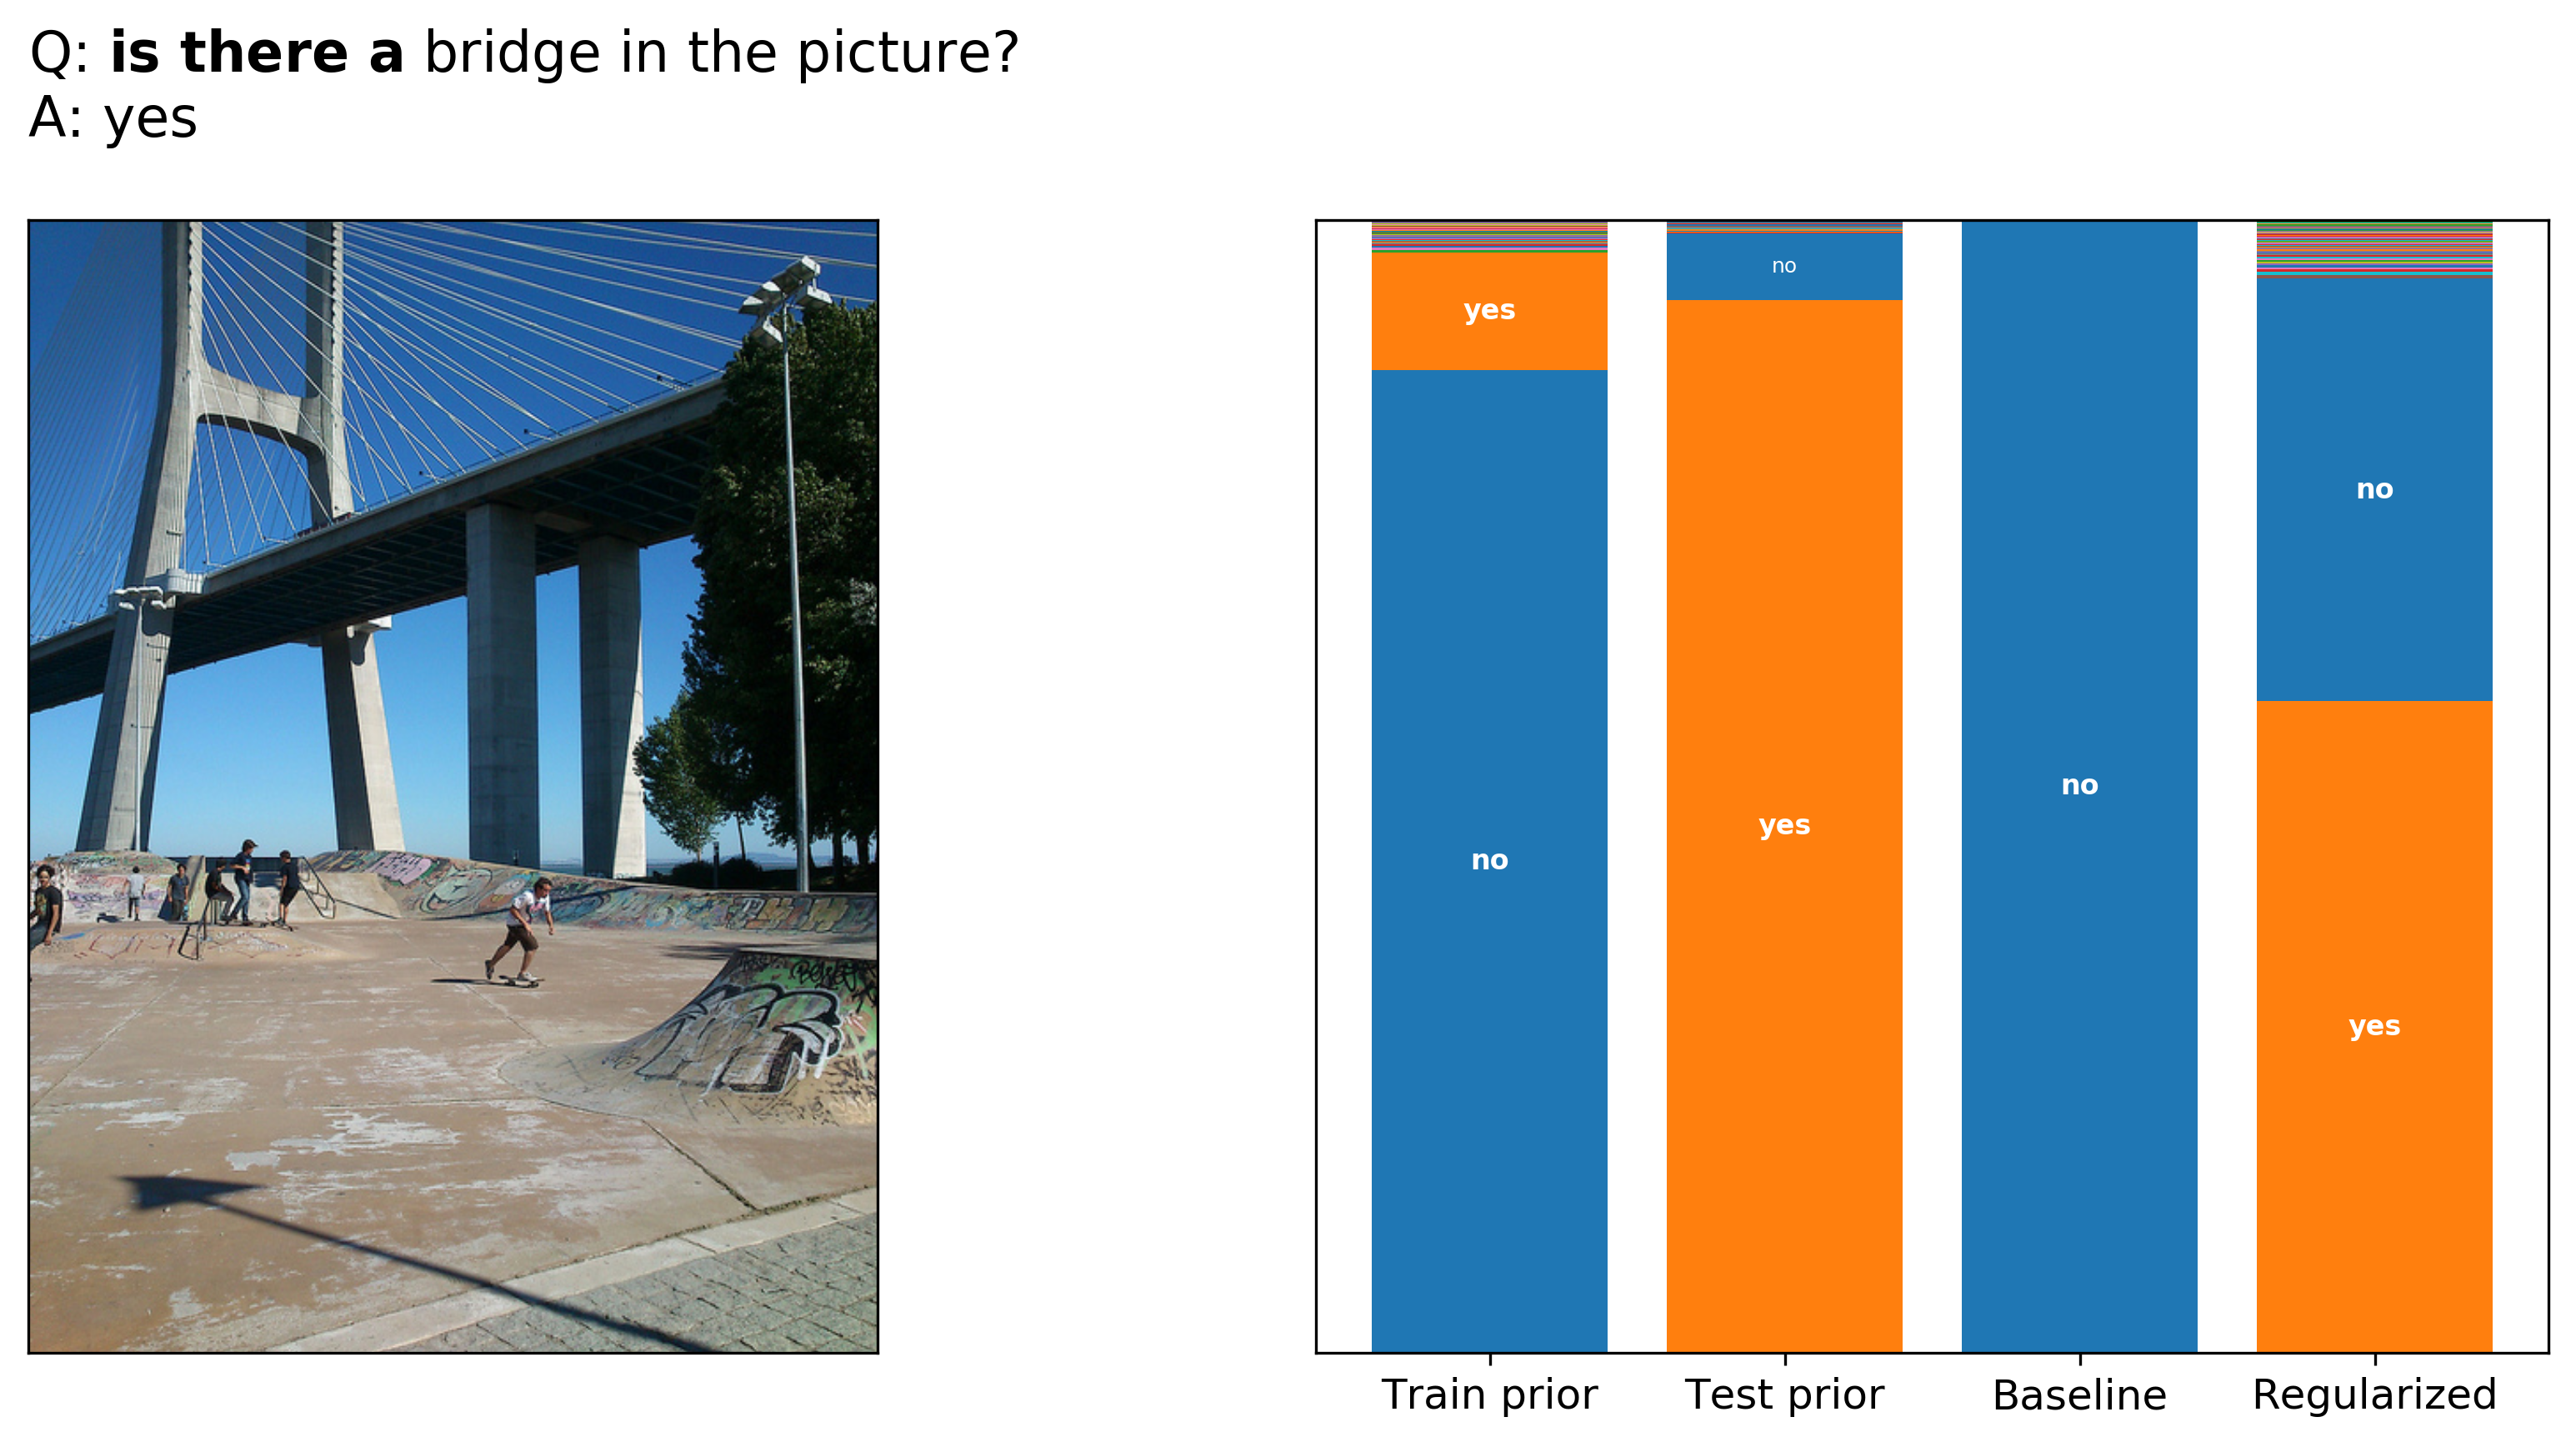

In [113]:
QTYPE = 'is there a'
QNUM = 56

trainsplit_prior = get_qtype_prior(QTYPE, trainsplit_types)
test_prior = get_qtype_prior(QTYPE, test_types)

baseline_dist = sort_model_scores(baseline_scores, QNUM)
regularized_dist = sort_model_scores(regularized_scores, QNUM)

image_name = baseline_info['image_name'][QNUM]
if 'train' in image_name:
    image_path = 'coco/train2014'
elif 'val' in image_name:
    image_path = 'coco/val2014'
else:
    raise ValueError
    
question = baseline_info['question_str'][QNUM]
answer = baseline_info['valid_answers'][0][QNUM]

qquoted = QTYPE.replace(' ', '\ ')
pattern = re.compile(QTYPE, re.IGNORECASE)
qrest = pattern.sub('', question)
txt = 'Q: ' + r"$\bf{" + qquoted + "}$" + qrest + '\nA: ' + answer + '\n'

fig = plot_comparison(trainsplit_prior, test_prior, baseline_dist, regularized_dist)

fig.add_subplot(121)
ax = plt.gca()

plt.title(txt, FontSize=16, horizontalalignment='left', x=0.0)

ax.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

img = mpimg.imread(os.path.join(image_path, image_name + '.jpg'))
imgplot = ax.imshow(img, interpolation='bilinear')

In [ ]:
A = np.array(baseline_info['valid_answers'][0])
ii = np.where(A == 'yes')[0]
ii.shape

In [ ]:
np.where(np.array(baseline_answers)[ii] == 'yes')[0].shape

In [ ]:
np.where(np.array(regularized_answers)[ii] == 'yes')[0].shape

In [ ]:
baseline_info['valid_answers']